In [1]:
### General imports
import xarray as xr
import numpy as np
import pandas as pd
import random
import re
import urllib.request

# Stats and pyMC
import pymc as pm
import pymc.math as pm_math
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm
from scipy import signal
from scipy.signal import detrend
from scipy.stats import norm

### Plots
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgb
from matplotlib.gridspec import GridSpec
import seaborn as sns


In [2]:
def fit_ols(X, y):
    """OLS with MLE sigma^2 and Gaussian log-likelihood."""
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - X @ beta
    n = y.size
    rss = float(resid @ resid)
    sigma2_mle = rss / n
    ll = -0.5 * n * (np.log(2 * np.pi * sigma2_mle) + 1.0)  # Gaussian i.i.d.
    return beta, ll, rss

### Interpretation of Bayes Factors
def interpret_bayes_factor(BF,model1_name='H1', model2_name='H0'):
    if 1 <= BF < 3:
        return "Anecdotal evidence for " + model1_name 
    elif 3 <= BF < 10:
        return "Substantial evidence for " + model1_name
    elif 10 <= BF < 30:
        return "Strong evidence for " + model1_name
    elif 30 <= BF < 100:
        return "Very strong evidence for " + model1_name
    ### Now the same with 1/BF
    elif BF >= 100:
        return "Decisive evidence for " + model1_name
    elif 1/3 < BF < 1:
        return "Anecdotal evidence for " + model2_name 
    elif 1/10 < BF <= 1/3:
        return "Substantial evidence for " + model2_name
    elif 1/30 < BF <= 1/10:
        return "Strong evidence for " + model2_name
    elif 1/100 < BF <= 1/30:
        return "Very strong evidence for " + model2_name
    elif BF <= 1/100:
        return "Decisive evidence for " + model2_name
    else:
        return "No evidence"

In [3]:
temp_data_hadCRUT3_old = xr.open_dataset('/home/jmindlin/BF_codes/data/HadCRUT3_archive_dec_2009.nc')
temp_hadCRUT3 = temp_data_hadCRUT3_old.mean(dim='latitude').mean(dim='longitude').temp

In [4]:
temp_data_hadCRUT3_corrected = xr.open_dataset('/home/jmindlin/BF_codes/data/HadCRUT3.nc')
temp_hadCRUT3_corrected = temp_data_hadCRUT3_corrected.mean(dim='latitude').mean(dim='longitude').temp

In [5]:
# URL of the data file
url = "https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT5.0Analysis_gl.txt"

# Fetch the data from the URL
with urllib.request.urlopen(url) as response:
    lines = response.read().decode('utf-8').splitlines()

# Parse the lines to extract the data
data = []
months = []
years = []
for line in lines[::2]:
    values = line.split(' ')[2:-1]
    years.append(line.split(' ')[0])
    years.append(line.split(' ')[1])
    for i, value in enumerate(values):
        if value != '':
            data.append(value)
            months.append(i)

# Convert the list of lists into a NumPy array
data_array = np.array(data, dtype=float)
data_array = data_array

# Print the resulting NumPy array
print(data_array)

time = pd.date_range(start='1850-01-01', end='2025-12-01', freq='MS')
temperature_data = xr.DataArray(
    data_array[:], 
    coords={'time': time}, 
    dims='time', 
    name='temperature - HadCRU5'
)

### HadCRUT5 short
temp_hadCRUT5_da = (
    temperature_data
    .sel(time=slice("1979","2009"))
    .groupby("time.year").mean("time")
)
temp_hadCRUT5 = temp_hadCRUT5_da.values.astype(float)
temp_hadCRUT5_year = temp_hadCRUT5_da.year.values.astype(float)


### HadCRUT5 long
temp_hadCRUT5_long_da = (
    temperature_data
    .sel(time=slice("1979","2012"))
    .groupby("time.year").mean("time")
)
temp_hadCRUT5_2012 = temp_hadCRUT5_long_da.values.astype(float)
temp_hadCRUT5_year_2012 = temp_hadCRUT5_long_da.year.values.astype(float)

[-0.734 -0.36  -0.627 ... -9.999 -9.999 -9.999]


In [6]:
### Color list 
dark_oranges = sns.color_palette("Oranges", n_colors=15)[4:]
dark_purples = sns.color_palette("Purples", n_colors=9)[4:]
dark_greens = sns.color_palette("Greens", n_colors=9)[4:]

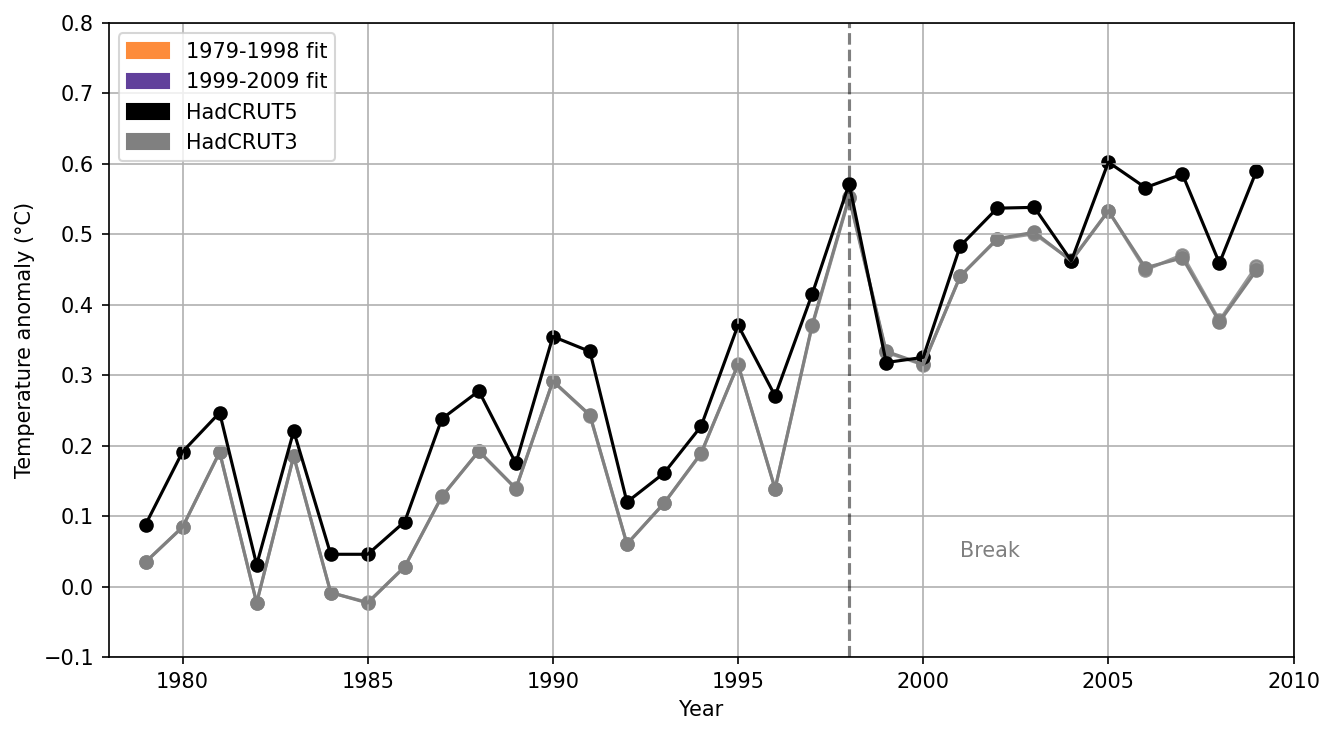

In [7]:
### HadCRUT3 old
temp = temp_hadCRUT3.sel(t=slice('1979','2009')).groupby('t.year').mean('t').values.reshape([-1])
years = temp_hadCRUT3.sel(t=slice('1979','2009')).groupby('t.year').mean('t').year.values
# 3) Fit and compute log-likelihoods
X0 = np.column_stack([np.ones(len(years[:20])), years[:20]])
beta0, ll0, rss0 = fit_ols(X0, temp[:20])
X1 = np.column_stack([np.ones(len(years[20:])), years[20:]])
beta1, ll1, rss1 = fit_ols(X1,temp[20:])

### HadCRUT3 corrected
temp_corr = temp_hadCRUT3_corrected.sel(t=slice('1979','2009')).groupby('t.year').mean('t').values.reshape([-1])
years = temp_hadCRUT3_corrected.sel(t=slice('1979','2009')).groupby('t.year').mean('t').year.values
# 3) Fit and compute log-likelihoods
X0 = np.column_stack([np.ones(len(years[:20])), years[:20]])
beta0_corr, ll0_corr, rss0_corr = fit_ols(X0, temp[:20])
X1 = np.column_stack([np.ones(len(years[20:])), years[20:]])
beta1_corr, ll1_corr, rss1_corr = fit_ols(X1,temp[20:])

### HadCRUT5 (in temperature_data)
temp_hadCRUT5 = (
    temperature_data
    .sel(time=slice("1979","2009"))
    .groupby("time.year").mean("time")
)
temp_cru5 = temp_hadCRUT5.values.astype(float)
t_year = temp_hadCRUT5.year.values.astype(float)

### Plot HadCRUT3 old and corrected with the individual fits

plt.figure(figsize=(9,5),dpi=150)
plt.plot(years,temp,color='grey', label='HadCRUT3 (old)' ,alpha=0.8)
plt.scatter(years,temp,color='grey',alpha=0.8)

plt.plot(years,temp_corr,color='grey', label='HadCRUT3 (corrected)')
plt.scatter(years,temp_corr,color='grey')

#add hadCRUT5
plt.plot(t_year,temp_cru5,color='k',label='HadCRUT5')
plt.scatter(t_year,temp_cru5,color='k')

#Legend
red_patch = mpatches.Patch(color=dark_oranges[3], label='1979-1998 fit')
blue_patch = mpatches.Patch(color=dark_purples[3], label='1999-2009 fit')
data_patch = mpatches.Patch(color='k', label='HadCRUT5')
### Add HadCRUT3 pathches
grey_patch = mpatches.Patch(color='grey', label='HadCRUT3')
plt.legend(handles=[red_patch, blue_patch, data_patch, grey_patch], loc='upper left')
# Another legend with the datasets (black grey)
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.axvline(x=1998, color='k', linestyle='--', alpha=0.5)
plt.text(2001,0.05, 'Break', rotation=0, verticalalignment='center', color='k', alpha=0.5)
plt.ylim(-0.1,0.8)
plt.xlim(1978,2010)
plt.grid()
plt.tight_layout()



In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# === FUNCIÓN PARA CALCULAR BAYES FACTOR ===
def bayes_factor_breakpoint(t, y, break_year):
    """
    Calcula el Bayes Factor entre:
    H0: tendencia lineal en todo el período
    H1: lineal hasta break_year, luego flat
    """
    t = np.array(t)
    y = np.array(y)
    n = len(y)
    
    # Identificar índice del breakpoint
    tau = np.where(t.astype('datetime64[Y]').astype(int) == break_year)[0][0]
    
    # --- H0: Lineal ---
    X0 = t.reshape(-1,1)
    model0 = LinearRegression().fit(X0, y)
    rss0 = np.sum((y - model0.predict(X0))**2)
    k0 = 2  # intercept + slope
    BIC0 = n * np.log(rss0/n) + k0 * np.log(n)
    
    # --- H1: Lineal hasta breakpoint, luego plano ---
    # Segmento 1
    X1a = t[:tau].reshape(-1,1)
    y1a = y[:tau]
    model1a = LinearRegression().fit(X1a, y1a)
    rss1a = np.sum((y1a - model1a.predict(X1a))**2)
    k1a = 2
    
    # Segmento 2
    X1b = t[tau:].reshape(-1,1)
    y1b = y[tau:]
    model1b = LinearRegression().fit(np.ones_like(X1b), y1b)
    rss1b = np.sum((y1b - model1b.predict(np.ones_like(X1b)))**2)
    k1b = 1
    
    # BIC H1
    BIC1 = n * np.log((rss1a + rss1b)/n) + (k1a + k1b) * np.log(n)
    
    # Bayes Factor
    BF = np.exp(-(BIC1 - BIC0)/2)
    return BF

In [9]:
BFs = {}

temp_hadCRUT3_values = temp_hadCRUT3.sel(t=slice('1979','2009')).groupby('t.year').mean('t').values.reshape([-1])
temp_hadCRUT3_years = temp_hadCRUT3.sel(t=slice('1979','2009')).groupby('t.year').mean('t').year.values
BFs["HadCRUT3"] = bayes_factor_breakpoint(temp_hadCRUT3_years, temp_hadCRUT3_values, 1998)

temp_hadCRUT3_corrected_values = temp_hadCRUT3_corrected.sel(t=slice('1979','2009')).groupby('t.year').mean('t').values.reshape([-1])
temp_hadCRUT3_corrected_years = temp_hadCRUT3_corrected.sel(t=slice('1979','2009')).groupby('t.year').mean('t').year.values
BFs["HadCRUT3_corrected"] = bayes_factor_breakpoint(temp_hadCRUT3_corrected_years, temp_hadCRUT3_corrected_values, 1998)


temp_hadCRUT5_values = temp_hadCRUT5_da.values.reshape([-1])
temp_hadCRUT5_years = temp_hadCRUT5_da.year.values
BFs["HadCRUT5"] = bayes_factor_breakpoint(temp_hadCRUT5_years, temp_hadCRUT5_values, 1998)

temp_hadCRUT5_long_values = temp_hadCRUT5_long_da.values.reshape([-1])
temp_hadCRUT5_long_years = temp_hadCRUT5_long_da.year.values
BFs["HadCRUT5_2012"] = bayes_factor_breakpoint(temp_hadCRUT5_long_years, temp_hadCRUT5_long_values, 1998)

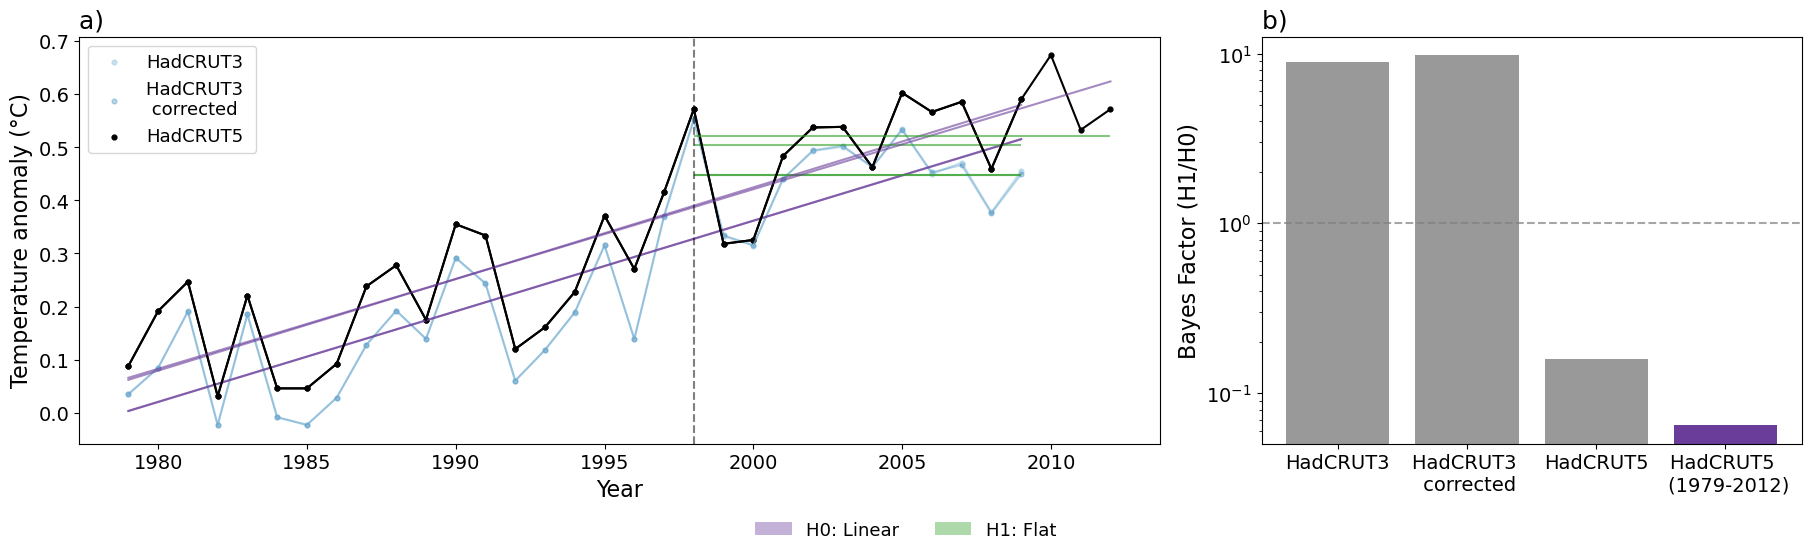

In [10]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.colors import to_rgb
import numpy as np

# --- Función para shading de color ---
def lighten(hex_color, amount=0.5):
    r, g, b = to_rgb(hex_color)
    r = r + (1 - r) * amount
    g = g + (1 - g) * amount
    b = b + (1 - b) * amount
    return (r, g, b)

# --- Colores para hipótesis y datasets ---
H_COL = {"H0": "#6a3d9a",  # violeta
         "H1": "#33a02c"}  # verde (flat)
COL_H3_OLD  = (0.55, 0.55, 0.55)
COL_H3_CORR = (0.35, 0.35, 0.35)
COL_H5      = (0.00, 0.00, 0.00)

COL_H3_OLD = "#a6cee3"   # light blue
COL_H3_CORR = "#1f78b4"  # darker blue
COL_H5 = "#000000"        # black, keep

# --- Fuente y tamaños ---
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 16
TICK_FONTSIZE  = 14
LEGEND_FONTSIZE = 13

# --- Armar lista de bases de datos y shadings ---
datasets = [
    ("HadCRUT3", temp_hadCRUT3_years, temp_hadCRUT3_values, COL_H3_OLD, 0.6),
    ("HadCRUT3 \n corrected", temp_hadCRUT3_corrected_years, temp_hadCRUT3_corrected_values, COL_H3_CORR, 0.3),
    ("HadCRUT5", temp_hadCRUT5_years, temp_hadCRUT5_values, COL_H5, 1.0),
    (" ", temp_hadCRUT5_long_years, temp_hadCRUT5_long_values, COL_H5, 1.0)
]

# --- Crear figura ---
fig = plt.figure(figsize=(18,5), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig, width_ratios=[2,1])
axA = fig.add_subplot(gs[0])
axB = fig.add_subplot(gs[1])

# --- PANEL A: Serie temporal ---
for name, years, temp, base_col, alpha in datasets:
    axA.plot(years, temp, color=base_col, alpha=alpha)
    if name == " ":
        axA.scatter(years, temp, color=base_col, alpha=alpha, s=12)
    else:
        axA.scatter(years, temp, color=base_col, alpha=alpha, s=12, label=name)
    
    # Lineal
    model = np.polyfit(np.arange(len(years)), temp, 1)
    trend = np.polyval(model, np.arange(len(years)))
    axA.plot(years, trend, color=H_COL["H0"], alpha=0.6)
    
    # Flat post-1998
    tau = np.where(years.astype('datetime64[Y]').astype(int) == 1998)[0][0]
    mean_post = np.mean(temp[tau:])
    axA.hlines(mean_post, years[tau], years[-1], color=H_COL["H1"], alpha=0.6)

axA.axvline(1998, color='k', linestyle='--', alpha=0.5)

axA.set_xlabel("Year", fontsize=LABEL_FONTSIZE)
axA.set_ylabel("Temperature anomaly (°C)", fontsize=LABEL_FONTSIZE)
axA.set_title("a) ", loc='left', fontsize=TITLE_FONTSIZE)
axA.tick_params(axis='both', labelsize=TICK_FONTSIZE)
axA.legend(fontsize=LEGEND_FONTSIZE)

# --- PANEL B: Bayes Factors vertical ---
bf_labels = list(BFs.keys())
bf_labels_ticks = ["HadCRUT3", "HadCRUT3 \n corrected", "HadCRUT5", "HadCRUT5 \n (1979-2012)"]
bf_values = [BFs[k] for k in bf_labels]

bf_colors = []
for k, v in zip(bf_labels, bf_values):
    # gris si BF no es decisivo
    if 0.1 <= v <= 10:
        bf_colors.append((0.6,0.6,0.6))
        continue
    # elegir color según hipótesis ganadora
    base_color = H_COL["H0"] if v < 1 else H_COL["H1"]  # violeta=lineal, verde=flat
    if "HadCRUT3_corrected" in k:
        bf_colors.append(lighten(base_color, 0.3))
    elif "HadCRUT3" in k:
        bf_colors.append(lighten(base_color, 0.6))
    else:
        bf_colors.append(base_color)

axB.bar(bf_labels_ticks, bf_values, color=bf_colors)
axB.set_yscale('log')  # eje Y en escala logarítmica
axB.axhline(1, color='gray', linestyle='--', alpha=0.7)  # BF=1, referencia
axB.set_ylabel("Bayes Factor (H1/H0)", fontsize=LABEL_FONTSIZE)
axB.set_title("b) ", loc='left', fontsize=TITLE_FONTSIZE)
axB.tick_params(axis='both', labelsize=TICK_FONTSIZE)

# --- Leyenda combinada ---
handles = [
    Patch(facecolor=lighten(H_COL["H0"],0.6), label="H0: Linear"),
    Patch(facecolor=lighten(H_COL["H1"],0.6), label="H1: Flat"),
]

fig.legend(
    handles=handles, loc="lower center", ncol=5, frameon=False,
    bbox_to_anchor=(0.5, -0.1),  # bajar un poco más
    fontsize=LEGEND_FONTSIZE
)

plt.show()


### Using pyMC

In [11]:

def fit_H0_MCMC(years, temp, draws=2000, tune=1000):
    """
    Ajuste lineal simple: y = alpha + beta * t
    """
    # Convertir a float64
    temp = np.asarray(temp, dtype=np.float64)
    t    = np.arange(len(temp), dtype=np.float64)
    
    with pm.Model() as model:
        alpha = pm.Normal("alpha", mu=0, sigma=10)
        beta  = pm.Normal("beta", mu=0, sigma=1)
        sigma = pm.HalfNormal("sigma", sigma=1)
        
        mu = alpha + beta * t
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=temp)
        
        trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95, progressbar=False)
    return trace

def fit_H1_flat_MCMC(years, temp, cutoff_year=1998, draws=2000, tune=1000):
    """
    Modelo "flat post-cutoff": y = alpha1 (pre-cutoff), alpha2 (post-cutoff)
    """
    temp = np.asarray(temp, dtype=np.float64)
    t    = np.arange(len(temp), dtype=np.float64)
    
    # identificar índice del cutoff
    cutoff_index = np.argmin(np.abs(years - cutoff_year))
    
    with pm.Model() as model:
        alpha1 = pm.Normal("alpha1", mu=0, sigma=10)
        alpha2 = pm.Normal("alpha2", mu=0, sigma=10)
        sigma  = pm.HalfNormal("sigma", sigma=1)
        
        # usar pm.math.concatenate para evitar dtype=object
        mu = pm_math.concatenate([
            pm_math.ones(cutoff_index) * alpha1,
            pm_math.ones(len(temp) - cutoff_index) * alpha2
        ])
        
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=temp)
        trace = pm.sample(draws=draws, tune=tune, chains=2, target_accept=0.95, progressbar=False)
        
    return trace

In [12]:

def bayes_factor_pymc(trace_H0, trace_H1, years, temp, breakpoint=1998):
    # Punto fijo: media posterior
    theta_H0 = {var: trace_H0.posterior[var].mean().item() for var in ["alpha","beta","sigma"]}
    theta_H1 = {var: trace_H1.posterior[var].mean().item() for var in ["alpha1","alpha2","sigma"]}
    
    # Verosimilitud en el punto fijo
    t = np.arange(len(years))
    mu_H0 = theta_H0["alpha"] + theta_H0["beta"] * t
    mu_H1 = np.concatenate([np.full(np.where(years.astype('datetime64[Y]').astype(int)==breakpoint)[0][0], theta_H1["alpha1"]),
                            np.full(len(years) - np.where(years.astype('datetime64[Y]').astype(int)==breakpoint)[0][0], theta_H1["alpha2"])])
    
    log_like_H0 = np.sum(norm.logpdf(temp, loc=mu_H0, scale=theta_H0["sigma"]))
    log_like_H1 = np.sum(norm.logpdf(temp, loc=mu_H1, scale=theta_H1["sigma"]))
    
    # Priors: normales simples, independientes
    log_prior_H0 = norm.logpdf(theta_H0["alpha"], 0, 10) + norm.logpdf(theta_H0["beta"], 0, 1) + \
                   np.log(theta_H0["sigma"])  # approx for HalfNormal
    log_prior_H1 = norm.logpdf(theta_H1["alpha1"], 0, 10) + norm.logpdf(theta_H1["alpha2"], 0, 10) + \
                   np.log(theta_H1["sigma"])
    
    # Posterior densidad aproximada con KDE
    kde_H0_alpha = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(trace_H0.posterior["alpha"].values.reshape(-1,1))
    kde_H0_beta  = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(trace_H0.posterior["beta"].values.reshape(-1,1))
    kde_H0_sigma = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(trace_H0.posterior["sigma"].values.reshape(-1,1))
    
    log_post_H0 = kde_H0_alpha.score_samples([[theta_H0["alpha"]]])[0] + \
                  kde_H0_beta.score_samples([[theta_H0["beta"]]])[0] + \
                  kde_H0_sigma.score_samples([[theta_H0["sigma"]]])[0]
    
    kde_H1_alpha1 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(trace_H1.posterior["alpha1"].values.reshape(-1,1))
    kde_H1_alpha2 = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(trace_H1.posterior["alpha2"].values.reshape(-1,1))
    kde_H1_sigma  = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(trace_H1.posterior["sigma"].values.reshape(-1,1))
    
    log_post_H1 = kde_H1_alpha1.score_samples([[theta_H1["alpha1"]]])[0] + \
                  kde_H1_alpha2.score_samples([[theta_H1["alpha2"]]])[0] + \
                  kde_H1_sigma.score_samples([[theta_H1["sigma"]]])[0]
    
    # Evidencia marginal (log)
    log_marg_H0 = log_like_H0 + log_prior_H0 - log_post_H0
    log_marg_H1 = log_like_H1 + log_prior_H1 - log_post_H1
    
    BF = np.exp(log_marg_H1 - log_marg_H0)
    return BF


In [13]:
# HadCRUT3
trace_H0 = fit_H0_MCMC(temp_hadCRUT3_years, temp_hadCRUT3_values)
trace_H1 = fit_H1_flat_MCMC(temp_hadCRUT3_years, temp_hadCRUT3_values)
BF_HadCRUT3 = bayes_factor_pymc(trace_H0, trace_H1, temp_hadCRUT3_years, temp_hadCRUT3_values)
print("BF HadCRUT3:", BF_HadCRUT3)

# HadCRUT5
trace_H0 = fit_H0_MCMC(temp_hadCRUT5_years, temp_hadCRUT5_values)
trace_H1 = fit_H1_flat_MCMC(temp_hadCRUT5_years, temp_hadCRUT5_values)
BF_HadCRUT5 = bayes_factor_pymc(trace_H0, trace_H1, temp_hadCRUT5_years, temp_hadCRUT5_values)
print("BF HadCRUT5:", BF_HadCRUT5)


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha1, alpha2, sigma]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...


BF HadCRUT3: 0.0317096283858784


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha1, alpha2, sigma]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


BF HadCRUT5: 0.0013773925643121988


In [14]:
# --- Diccionario para Bayes Factors usando Chib/MCMC ---
BFs_chib = {}

# HadCRUT3
temp_hadCRUT3_values = temp_hadCRUT3.sel(t=slice('1979','2009')).groupby('t.year').mean('t').values.reshape([-1])
temp_hadCRUT3_years = temp_hadCRUT3.sel(t=slice('1979','2009')).groupby('t.year').mean('t').year.values
trace_H0 = fit_H0_MCMC(temp_hadCRUT3_years, temp_hadCRUT3_values)
trace_H1 = fit_H1_flat_MCMC(temp_hadCRUT3_years, temp_hadCRUT3_values)
BFs_chib["HadCRUT3"] = bayes_factor_pymc(trace_H0, trace_H1, temp_hadCRUT3_years, temp_hadCRUT3_values)

# HadCRUT3 corrected
temp_hadCRUT3_corrected_values = temp_hadCRUT3_corrected.sel(t=slice('1979','2009')).groupby('t.year').mean('t').values.reshape([-1])
temp_hadCRUT3_corrected_years = temp_hadCRUT3_corrected.sel(t=slice('1979','2009')).groupby('t.year').mean('t').year.values
trace_H0 = fit_H0_MCMC(temp_hadCRUT3_corrected_years, temp_hadCRUT3_corrected_values)
trace_H1 = fit_H1_flat_MCMC(temp_hadCRUT3_corrected_years, temp_hadCRUT3_corrected_values)
BFs_chib["HadCRUT3_corrected"] = bayes_factor_pymc(trace_H0, trace_H1, temp_hadCRUT3_corrected_years, temp_hadCRUT3_corrected_values)

# HadCRUT5
temp_hadCRUT5_values = temp_hadCRUT5_da.values.reshape([-1])
temp_hadCRUT5_years = temp_hadCRUT5_da.year.values
trace_H0 = fit_H0_MCMC(temp_hadCRUT5_years, temp_hadCRUT5_values)
trace_H1 = fit_H1_flat_MCMC(temp_hadCRUT5_years, temp_hadCRUT5_values)
BFs_chib["HadCRUT5"] = bayes_factor_pymc(trace_H0, trace_H1, temp_hadCRUT5_years, temp_hadCRUT5_values)

# HadCRUT5 long (1979-2012)
temp_hadCRUT5_long_values = temp_hadCRUT5_long_da.values.reshape([-1])
temp_hadCRUT5_long_years = temp_hadCRUT5_long_da.year.values
trace_H0 = fit_H0_MCMC(temp_hadCRUT5_long_years, temp_hadCRUT5_long_values)
trace_H1 = fit_H1_flat_MCMC(temp_hadCRUT5_long_years, temp_hadCRUT5_long_values)
BFs_chib["HadCRUT5_2012"] = bayes_factor_pymc(trace_H0, trace_H1, temp_hadCRUT5_long_years, temp_hadCRUT5_long_values)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha1, alpha2, sigma]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha1, alpha2, sigma]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000

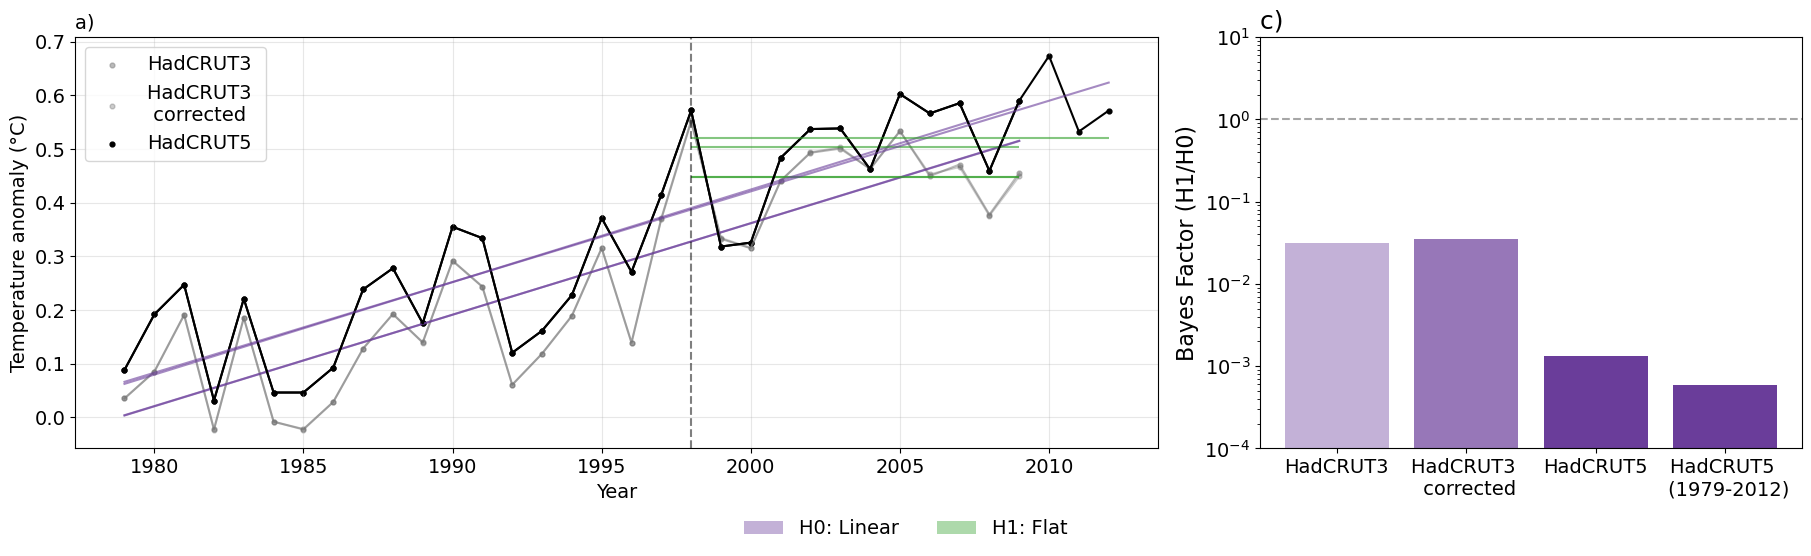

In [15]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
from matplotlib.colors import to_rgb
import numpy as np

# --- Función para shading de color ---
def lighten(hex_color, amount=0.5):
    r, g, b = to_rgb(hex_color)
    r = r + (1 - r) * amount
    g = g + (1 - g) * amount
    b = b + (1 - b) * amount
    return (r, g, b)

# --- Colores para hipótesis y datasets ---
H_COL = {"H0": "#6a3d9a",  # violeta
         "H1": "#33a02c"}  # verde (flat)
COL_H3_OLD  = (0.55, 0.55, 0.55)
COL_H3_CORR = (0.35, 0.35, 0.35)
COL_H5      = (0.00, 0.00, 0.00)

# --- Fuente y tamaños homogéneos ---
FS = 14

# --- Armar lista de bases de datos y shadings ---
datasets = [
    ("HadCRUT3", temp_hadCRUT3_years, temp_hadCRUT3_values, COL_H3_OLD, 0.6),
    ("HadCRUT3 \n corrected", temp_hadCRUT3_corrected_years, temp_hadCRUT3_corrected_values, COL_H3_CORR, 0.3),
    ("HadCRUT5", temp_hadCRUT5_years, temp_hadCRUT5_values, COL_H5, 1.0),
    (" ", temp_hadCRUT5_long_years, temp_hadCRUT5_long_values, COL_H5, 1.0)
]

# --- Crear figura ---
fig = plt.figure(figsize=(18,5), constrained_layout=True)
gs = GridSpec(1, 2, figure=fig, width_ratios=[2,1])
axA = fig.add_subplot(gs[0])
axB = fig.add_subplot(gs[1])

# --- PANEL A: Serie temporal ---
for name, years, temp, base_col, alpha in datasets:
    axA.plot(years, temp, color=base_col, alpha=alpha)
    if name == " ":
        axA.scatter(years, temp, color=base_col, alpha=alpha, s=12)
    else:
        axA.scatter(years, temp, color=base_col, alpha=alpha, s=12, label=name)
    
    # Lineal
    model = np.polyfit(np.arange(len(years)), temp, 1)
    trend = np.polyval(model, np.arange(len(years)))
    axA.plot(years, trend, color=H_COL["H0"], alpha=0.6)
    
    # Flat post-1998
    tau = np.where(years.astype('datetime64[Y]').astype(int) == 1998)[0][0]
    mean_post = np.mean(temp[tau:])
    axA.hlines(mean_post, years[tau], years[-1], color=H_COL["H1"], alpha=0.6)

axA.axvline(1998, color='k', linestyle='--', alpha=0.5)
axA.set_xlabel("Year", fontsize=FS)
axA.set_ylabel("Temperature anomaly (°C)", fontsize=FS)
axA.set_title("a) ", loc='left', fontsize=FS)
axA.legend(fontsize=FS)
axA.grid(alpha=0.3)
axA.tick_params(axis='both', labelsize=FS)

# --- PANEL B: Bayes Factors vertical ---
bf_labels = list(BFs_chib.keys())
bf_labels_ticks = ["HadCRUT3", "HadCRUT3 \n corrected", "HadCRUT5", "HadCRUT5 \n (1979-2012)"]
bf_values = [BFs_chib[k] for k in bf_labels]

bf_colors = []
for k, v in zip(bf_labels, bf_values):
    # gris si BF no es decisivo
    if 0.1 <= v <= 10:
        bf_colors.append((0.6,0.6,0.6))
        continue
    # elegir color según hipótesis ganadora
    base_color = H_COL["H0"] if v < 1 else H_COL["H1"]  # violeta=lineal, verde=flat
    if "HadCRUT3_corrected" in k:
        bf_colors.append(lighten(base_color, 0.3))
    elif "HadCRUT3" in k:
        bf_colors.append(lighten(base_color, 0.6))
    else:
        bf_colors.append(base_color)


# --- PANEL B: Bayes Factors vertical ---
axB.bar(bf_labels_ticks, bf_values, color=bf_colors)
axB.set_yscale('log')  # eje Y en escala logarítmica
axB.set_ylim(0.0001, 10)
axB.axhline(1, color='gray', linestyle='--', alpha=0.7)  # BF=1, referencia
axB.set_ylabel("Bayes Factor (H1/H0)", fontsize=LABEL_FONTSIZE)
axB.set_title("c) ", loc='left', fontsize=TITLE_FONTSIZE)
axB.tick_params(axis='both', labelsize=TICK_FONTSIZE)


# --- Leyenda combinada ---
handles = [
    Patch(facecolor=lighten(H_COL["H0"],0.6), label="H0: Linear"),
    Patch(facecolor=lighten(H_COL["H1"],0.6), label="H1: Flat"),
]

fig.legend(
    handles=handles, loc="lower center", ncol=5, frameon=False,
    bbox_to_anchor=(0.5, -0.1),  # bajar un poco más
    fontsize=FS
)

plt.show()
